# Implicitly defined reachable sets within GCS

In [1]:
import numpy as np
from large_gcs.graph_generators.hor_vert_gcs import (
    create_simplest_hor_vert_graph,
    create_intermediate_line_hor_vert_graph,
)

# from explorations.hor_vert_gcs_bug import create_simplest_hor_vert_graph

from pydrake.all import MathematicalProgram, MathematicalProgramResult, Solve

import logging

logging.basicConfig(level=logging.WARN)
logging.getLogger("large_gcs").setLevel(logging.DEBUG)

## Simple Example Graph

INFO:large_gcs.graph.graph:Adding 5 vertices to graph...
100%|██████████| 5/5 [00:00<00:00, 18477.11it/s]


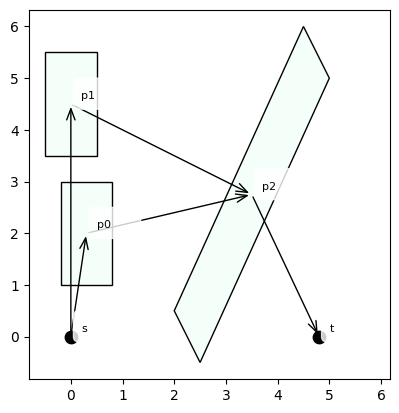

In [16]:
g = create_simplest_hor_vert_graph()
g.plot_sets()
g.plot_edges()
g.plot_set_labels()

INFO:large_gcs.graph.graph:Adding 6 vertices to graph...
100%|██████████| 6/6 [00:00<00:00, 49636.73it/s]


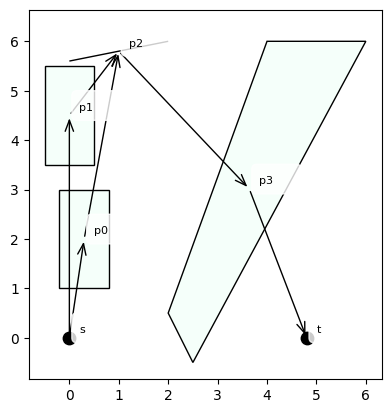

In [17]:
# g = create_simplest_hor_vert_graph()
g = create_intermediate_line_hor_vert_graph()
g.plot_sets()
g.plot_edges()
g.plot_set_labels()

INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=false and preprocessing=false and no rounding.


ShortestPathSolution(is_success=True, cost=15.999999997871182, time=0.006956806872040033, vertex_path=['s', 'p0', 'p2', 'p3', 't'], ambient_path=[array([0., 0.]), array([0.       , 2.0349857]), array([0. , 5.6]), array([4.8, 5.6]), array([4.8, 0. ])], flows=[1.0, 0.0, 1.0, 0.0, 1.0, 1.0], result=<pydrake.solvers.MathematicalProgramResult object at 0x7ff211038670>)

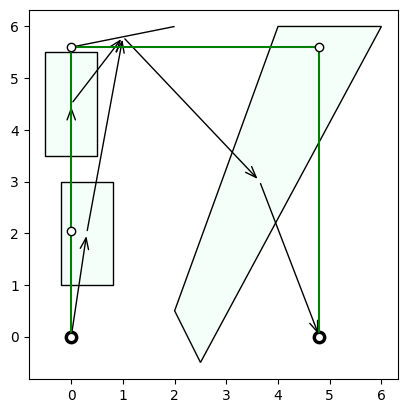

In [18]:
sol = g.solve_shortest_path()
g.plot_sets()
g.plot_edges()
g.plot_path(sol.ambient_path)
sol

In [5]:
print(g.edge_keys)
# sol_conv_res = g.solve_convex_restriction([("s", "p1"), ("p1", "p2"), ("p2", "t")])

# sol_conv_res
# g.plot_sets()
# g.plot_path(sol_conv_res.ambient_path)

["('s', 'p0')", "('s', 'p1')", "('p0', 'p2')", "('p1', 'p2')", "('p3', 't')", "('p2', 'p3')"]


In [6]:
for vertex_name, v in g.vertices.items():
    print(vertex_name, v.gcs_vertex.set().IsBounded())

s True
t True
p0 True
p1 True
p2 True
p3 True


# Sampling Procedure
To determine if A is dominated by B

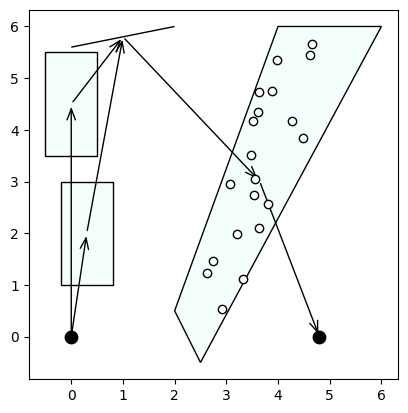

In [19]:
# Sample 100 points in p2
# p2_samples = np.array(g.vertices["p2"].convex_set.get_samples(100))
p3_samples = np.array(g.vertices["p3"].convex_set.get_samples(20))
g.plot_sets()
g.plot_edges()
g.plot_points(p3_samples)

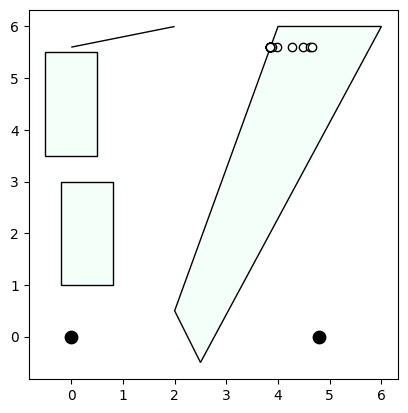

In [21]:
# Project these samples into revised set based on path


def project_sample_to_revised_set(samples, vertex_sampled, active_edges):
    prog = MathematicalProgram()
    vertex_names = [g.edges[active_edges[0]].u] + [g.edges[e].v for e in active_edges]
    # gcs vertices
    vertices = [g.vertices[name].gcs_vertex for name in vertex_names]
    edges = [g.edges[edge].gcs_edge for edge in active_edges]
    vertex_vars = [
        prog.NewContinuousVariables(
            rows=samples.shape[0], cols=v.ambient_dimension(), name=f"{v_name}_vars"
        )
        for v, v_name in zip(vertices, vertex_names)
    ]
    sample_vars = vertex_vars[vertex_names.index(vertex_sampled)]
    for v, v_name, v_vars in zip(vertices, vertex_names, vertex_vars):
        if v_name == vertex_sampled:
            for x, sample in zip(v_vars, samples):
                v.set().AddPointInSetConstraints(prog, x)
                # Add the distance to the sample as a cost
                prog.AddCost((x - sample).dot(x - sample))
                # Vertex Constraints
                for binding in v.GetConstraints():
                    constraint = binding.evaluator()
                    prog.AddConstraint(constraint, x)
        else:
            for x in v_vars:
                v.set().AddPointInSetConstraints(prog, x)

                # Vertex Constraints
                for binding in v.GetConstraints():
                    constraint = binding.evaluator()
                    prog.AddConstraint(constraint, x)

    for e, e_name in zip(edges, active_edges):
        # Edge Constraints
        for binding in e.GetConstraints():
            constraint = binding.evaluator()
            variables = binding.variables()
            u_name, v_name = g.edges[e_name].u, g.edges[e_name].v
            u_idx, v_idx = vertex_names.index(u_name), vertex_names.index(v_name)
            for ux, vx in zip(vertex_vars[u_idx], vertex_vars[v_idx]):
                variables[: len(ux)] = ux
                variables[-len(vx) :] = vx
                prog.AddConstraint(constraint, variables)

    result = Solve(prog)
    if not result.is_success():
        raise RuntimeError("Failed to solve")
    return result.GetSolution(sample_vars)


# active_edges = ["('s', 'p1')", "('p1', 'p2')"]
active_edges = ["('s', 'p1')", "('p1', 'p2')", "('p2', 'p3')"]
# active_edges = ["('s', 'p1')", "('p1', 'p2')", "('p2', 't')"]
new_samples = project_sample_to_revised_set(p3_samples, "p3", active_edges)
# print(new_samples)
g.plot_points(new_samples)
# g.plot_edges()
g.plot_sets()

# GcsAstarReachability

In [9]:
from large_gcs.algorithms.gcs_astar_reachability import GcsAstarReachability
from large_gcs.cost_estimators.shortcut_edge_ce import ShortcutEdgeCE
from large_gcs.graph.contact_cost_constraint_factory import (
    contact_shortcut_edge_cost_factory_over_obj_weighted,
)
from large_gcs.graph.cost_constraint_factory import (
    shortcut_edge_cost_factory,
)
import numpy as np

from large_gcs.graph_generators.hor_vert_gcs import (
    create_simplest_hor_vert_graph,
    create_polyhedral_hor_vert_graph,
    create_intermediate_line_hor_vert_graph,
)

# from explorations.hor_vert_gcs_bug import create_simplest_hor_vert_graph

import logging

logging.basicConfig(level=logging.WARN)
logging.getLogger("large_gcs").setLevel(logging.DEBUG)

In [10]:
g = create_simplest_hor_vert_graph()
# g = create_intermediate_line_hor_vert_graph()
# g = create_polyhedral_hor_vert_graph()
cost_estimator_se = ShortcutEdgeCE(g, shortcut_edge_cost_factory)
alg = GcsAstarReachability(g, cost_estimator_se, num_samples_per_vertex=5)
sol = alg.run()

INFO:large_gcs.graph.graph:Adding 5 vertices to graph...
100%|██████████| 5/5 [00:00<00:00, 23250.02it/s]
INFO:large_gcs.algorithms.gcs_astar_reachability:Running GcsAstarReachability
INFO:large_gcs.algorithms.gcs_astar_reachability:
n_vertices_expanded: {0: 1}, n_vertices_visited: {0: 0}, time_wall_clock: 0, n_gcs_solves: 0, gcs_solve_time_total: 0, gcs_solve_time_iter_mean: 0, gcs_solve_time_last_10_mean: 0, gcs_solve_time_iter_std: 0, gcs_solve_time_iter_min: inf, gcs_solve_time_iter_max: 0, n_vertices_reexpanded: {0: 0}, n_vertices_revisited: {0: 0}, n_Q: 0, n_S: 0, method_times: {'_generate_neighbors': 4.76837158203125e-06}, method_counts: {'_generate_neighbors': 1}
now exploring node s's 2 neighbors (0)
DEBUG:large_gcs.cost_estimators.shortcut_edge_ce:conv_res_active_edges: ["('s', 'p0')", "('p0', 't')_shortcut"]
DEBUG:large_gcs.cost_estimators.shortcut_edge_ce:Removing edge ('p0', 't')_shortcut
DEBUG:large_gcs.algorithms.gcs_astar_reachability:edge s -> p0 is feasible
DEBUG:larg

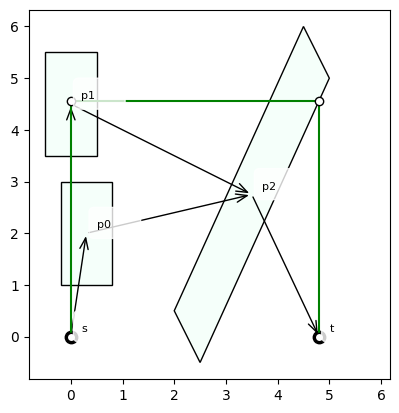

In [11]:
g.plot_sets()
g.plot_edges()
g.plot_set_labels()
g.plot_path(sol.ambient_path)

In [12]:
from large_gcs.algorithms.gcs_astar_convex_restriction import GcsAstarConvexRestriction

g = create_simplest_hor_vert_graph()
cost_estimator_se = ShortcutEdgeCE(g, shortcut_edge_cost_factory)
alg = GcsAstarConvexRestriction(g, cost_estimator_se)
sol = alg.run()

INFO:large_gcs.graph.graph:Adding 5 vertices to graph...
100%|██████████| 5/5 [00:00<00:00, 43781.88it/s]
INFO:large_gcs.algorithms.gcs_astar_convex_restriction:Running GcsAstarConvexRestriction, reexplore_level: ReexploreLevel.NONE
INFO:large_gcs.algorithms.gcs_astar_convex_restriction:
n_vertices_expanded: {0: 2}, n_vertices_visited: {0: 0}, time_wall_clock: 0, n_gcs_solves: 0, gcs_solve_time_total: 0, gcs_solve_time_iter_mean: 0, gcs_solve_time_last_10_mean: 0, gcs_solve_time_iter_std: 0, gcs_solve_time_iter_min: inf, gcs_solve_time_iter_max: 0, n_vertices_reexpanded: {0: 0}, n_vertices_revisited: {0: 0}, n_Q: 0, n_S: 0, method_times: {}, method_counts: {}
now exploring node s's 2 neighbors (0)
DEBUG:large_gcs.algorithms.gcs_astar_convex_restriction:edge s -> p0 is feasible, new dist: 5.903060218074425, added to pq True
DEBUG:large_gcs.algorithms.gcs_astar_convex_restriction:edge s -> p1 is feasible, new dist: 9.440538678543508, added to pq True
INFO:large_gcs.algorithms.gcs_astar_c

Note how GcsAstarConvexRestriction fails because it doesn't have the sampling to determine reachability procedure that GcsAstarReachability has

# Applying GcsAstarReachability to Contact Graph that fails for GcsAstarConvexRestriction
cg_maze_b1

In [13]:
from large_gcs.algorithms.gcs_astar_reachability import GcsAstarReachability
from large_gcs.cost_estimators.shortcut_edge_ce import ShortcutEdgeCE
from large_gcs.graph.contact_cost_constraint_factory import (
    contact_shortcut_edge_cost_factory_over_obj_weighted,
)
from large_gcs.graph.cost_constraint_factory import (
    shortcut_edge_cost_factory,
)
from large_gcs.algorithms.search_algorithm import SearchNode
from large_gcs.graph.graph import ShortestPathSolution
from large_gcs.graph.incremental_contact_graph import IncrementalContactGraph
from large_gcs.graph_generators.contact_graph_generator import (
    ContactGraphGeneratorParams,
)

import numpy as np
from IPython.display import HTML

import logging

logging.basicConfig(level=logging.WARN)
logging.getLogger("large_gcs").setLevel(logging.INFO)
logging.getLogger(__name__).setLevel(logging.DEBUG)
logger = logging.getLogger(__name__)

In [14]:
# cg_maze_b1_1 cg_maze_b1
graph_file = ContactGraphGeneratorParams.inc_graph_file_path_from_name("cg_maze_b1_1")
cg = IncrementalContactGraph.load_from_file(
    graph_file,
    should_incl_simul_mode_switches=False,
    should_add_const_edge_cost=True,
    should_add_gcs=True,
)
cost_estimator = ShortcutEdgeCE(
    cg,
    shortcut_edge_cost_factory=contact_shortcut_edge_cost_factory_over_obj_weighted,
)
alg = GcsAstarReachability(cg, cost_estimator, num_samples_per_vertex=5)
sol: ShortestPathSolution = alg.run()

INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 28826.83it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 17586.18it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 3 body pairs...
100%|██████████| 3/3 [00:00<00:00, 34.55it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (151)
100%|██████████| 151/151 [00:00<00:00, 562.01it/s]
INFO:large_gcs.algorithms.gcs_astar_reachability:Running GcsAstarReachability
INFO:large_gcs.algorithms.gcs_astar_reachability:
n_vertices_expanded: {0: 1}, n_vertices_visited: {0: 0}, time_wall_clock: 0, n_gcs_solves: 0, gcs_solve_time_total: 0, gcs_solve_time_iter_mean: 0, gcs_solve_time_last_10_mean: 0, gcs_solve_time_iter_std: 0, gcs_solve_time_iter_min: inf, gcs_solve_time_iter_max: 0, n_vertices_reexpanded: {0: 0}, n_vertices_revisited: {0: 0}, n_Q: 0, n_S: 0, method_times: {'_generate_neighbors': 6